## Perturbative footprint study: data creation

### Imports

In [75]:
# Standard imports
import numpy as np
import shutil
from ruamel.yaml import YAML
import os
import matplotlib.pyplot as plt
import pickle
import subprocess
import time
import pandas as pd

# Cern modules
import fillingpatterns as fp
import xtrack as xt

# Improve style
import matplotlib
import seaborn as sns

sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=0.8, rc={"lines.linewidth": 0.2, "grid.linewidth": 0.1})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

%config InlineBackend.figure_format='retina'


### Get machine (built in the script compare_footprints.py)

In [2]:
collider = xt.Multiline.from_json("output/collider_tuned_bb_on.json")
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


d78c3bfd220748e1b244d696fe29aebf.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from d78c3bfd220748e1b244d696fe29aebf.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


05a9dc7f9393476cb551d4602346d4e4.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 05a9dc7f9393476cb551d4602346d4e4.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Correct bbb schedule

In [3]:
# Get BB schedule
fname = "filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.json"
patt = fp.FillingPattern.from_json(fname)

# Compute bb schedule
patt.compute_beam_beam_schedule(n_lr_per_side=25)
bbs_b1 = patt.b1.bb_schedule
bbs_b2 = patt.b2.bb_schedule

# Get list of bunches
bbs_b1

Computing collision schedules...
Done Beam 1
Done Beam 2


,HO partner in ALICE,# of LR in ALICE,BB partners in ALICE,Positions in ALICE,HO partner in ATLAS/CMS,# of LR in ATLAS/CMS,BB partners in ATLAS/CMS,Positions in ATLAS/CMS,HO partner in LHCB,# of LR in LHCB,BB partners in LHCB,Positions in LHCB,collides in ATLAS/CMS,collides in ALICE,collides in LHCB
12,903.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",2682.0,29,"[2657.0, 2658.0, 2659.0, 2660.0, 2661.0, 2662....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",False,True,True
13,904.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",2683.0,28,"[2658.0, 2659.0, 2660.0, 2661.0, 2662.0, 2667....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",False,True,True
14,905.0,22,"[880.0, 881.0, 882.0, 883.0, 884.0, 885.0, 886...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",2684.0,27,"[2659.0, 2660.0, 2661.0, 2662.0, 2667.0, 2668....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",False,True,True
15,906.0,21,"[881.0, 882.0, 883.0, 884.0, 885.0, 886.0, 891...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",2685.0,26,"[2660.0, 2661.0, 2662.0, 2667.0, 2668.0, 2669....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",False,True,True
16,907.0,20,"[882.0, 883.0, 884.0, 885.0, 886.0, 891.0, 892...","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",2686.0,25,"[2661.0, 2662.0, 2667.0, 2668.0, 2669.0, 2670....","[-25.0, -24.0, -19.0, -18.0, -17.0, -16.0, -15...",False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,765.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",3438.0,21,"[3413.0, 3414.0, 3415.0, 3416.0, 3417.0, 3418....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",2544.0,21,"[2519.0, 2520.0, 2521.0, 2522.0, 2523.0, 2524....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",True,True,True
3439,766.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3439.0,20,"[3414.0, 3415.0, 3416.0, 3417.0, 3418.0, 3423....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",2545.0,20,"[2520.0, 2521.0, 2522.0, 2523.0, 2524.0, 2529....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",True,True,True
3440,767.0,22,"[742.0, 743.0, 744.0, 745.0, 746.0, 747.0, 748...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3440.0,19,"[3415.0, 3416.0, 3417.0, 3418.0, 3423.0, 3424....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",2546.0,19,"[2521.0, 2522.0, 2523.0, 2524.0, 2529.0, 2530....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",True,True,True
3441,768.0,21,"[743.0, 744.0, 745.0, 746.0, 747.0, 748.0, 753...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",3441.0,18,"[3416.0, 3417.0, 3418.0, 3423.0, 3424.0, 3425....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",2547.0,18,"[2522.0, 2523.0, 2524.0, 2529.0, 2530.0, 2531....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",True,True,True


In [4]:
def fix_bb_elements(collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False):
    # Reset collider
    if reset_collider:
        for i, x in enumerate(collider.lhcb1.element_names):
            if "bb_lr" in x or "bb_ho" in x:
                try:
                    collider.lhcb1.vars[x + '_scale_strength'] = collider.lhcb1.vars['beambeam_scale']
                    collider.lhcb1.element_refs[x].scale_strength = collider.lhcb1.vars[x + '_scale_strength']
                except Exception as e:
                    print(e)
                    print(f"Failed to reset {x}")
                    
                
        for i, x in enumerate(collider.lhcb2.element_names):
            if "bb_lr" in x or "bb_ho" in x:
                try:
                    collider.lhcb2.vars[x + '_scale_strength'] = collider.lhcb2.vars['beambeam_scale']
                    collider.lhcb2.element_refs[x].scale_strength = collider.lhcb2.vars[x + '_scale_strength']
                except Exception as e:
                    print(e)
                    print(f"Failed to reset {x}")

    # Take care of LR elements
    for ip, name_position in zip(
        [1, 2, 5, 8],
        [
            "Positions in ATLAS/CMS",
            "Positions in ALICE",
            "Positions in ATLAS/CMS",
            "Positions in LHCB",
        ],
    ):
        # Deactivate elements that shouldn't be here in beam 1
        idx_elements_b1 = bbs_b1.loc[bunch_nb][name_position]
        for i, x in enumerate(collider.lhcb1.element_names):
            # print(collider.lhcb1[x].to_dict())
            # First look for bb_elements for current IP
            if "bb_lr.l" + str(ip) in x or "bb_lr.r" + str(ip) in x:
                # Then only keep elements corresponding to the current IP
                pos = int(x.split("_")[2])
                if "l" in x.split("lr.")[1]:
                    pos = -pos
                if pos not in idx_elements_b1:
                    collider.lhcb1.element_refs[x].scale_strength = 0

        # Same with beam 2
        if also_beam_2:
            idx_elements_b2 = bbs_b2.loc[bunch_nb][name_position]
            for i, x in enumerate(collider.lhcb2.element_names):
                if "bb_lr.l" + str(ip) in x or "bb_lr.r" + str(ip) in x:
                    pos = int(x.split("_")[2])
                    if "l" in x.split("lr.")[1]:
                        pos = -pos
                    if pos not in idx_elements_b2:
                        collider.lhcb2.vars[x + '_scale_strength'] = 0

    # Take care of HO elements
    for ip, bool_collide in zip(
        [1, 2, 5, 8],
        ["collides in ATLAS/CMS", "collides in ALICE", "collides in ATLAS/CMS", "collides in LHCB"],
    ):
        collide_b1 = bbs_b1.loc[bunch_nb][bool_collide]

        # Deactivate elements that shouldn't be here in beam 1
        for i, x in enumerate(collider.lhcb1.element_names):
            # First look for bb_elements
            if (
                "bb_ho.l" + str(ip) in x or "bb_ho.r" + str(ip) in x or "bb_ho.c" + str(ip) in x
            ) and not collide_b1:
                collider.lhcb1.element_refs[x].scale_strength = 0

        # Same with beam 2
        if also_beam_2:
            collide_b2 = bbs_b2.loc[bunch_nb][bool_collide]
            for i, x in enumerate(collider.lhcb2.element_names):
                if (
                    "bb_ho.l" + str(ip) in x or "bb_ho.r" + str(ip) in x or "bb_ho.c" + str(ip) in x
                ) and not collide_b2:
                    collider.lhcb2.vars[x + '_scale_strength'] = 0

    # Print final result
    if print_final_result:
        # Beam 1
        print("Beam 1")
        for i, x in enumerate(collider.lhcb1.element_names):
            if "bb_ho" in x or "bb_lr" in x:
                print(x, collider.lhcb1.element_refs[x].scale_strength._value)

        # Beam 2
        if also_beam_2:
            print("Beam 2")
            for i, x in enumerate(collider.lhcb2.element_names):
                if "bb_ho" in x or "bb_lr" in x:
                    print(x, collider.lhcb2.element_refs[x].scale_strength._value)

    # Return collider
    return collider

### Get DA for each bunch

In [5]:
# Load dataframe for DA
path = "/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches"
df = pd.read_parquet(f"{path}/da.parquet")

# Round all numbers to 3 decimals
df = df.round(3)

# Get list of bunches and list of DA
l_bunch_nb_from_DA = df["bunch_nb"]
l_DA = df["normalized amplitude in xy-plane"]

Coupling correction due to the lattice (```delta_cmr``` and ```delta_cmi``` in pymask) are ignored as they're not very relevant for the coupling study.

### Get footprint for a selected set bunches

In [6]:
def return_footprint(collider, bunch_nb, n_turns, perturbative=True, mimic_initial_condition = False):
    # Adapt collider for current bunch
    collider = fix_bb_elements(
        collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False
    )
    # Get footprint
    if mimic_initial_condition:

        # First get initial condition that was built to compute DA
        r_max, r_min = 10, 2
        radial_list_to_mimic = np.linspace(r_min, r_max, 2 * 16 * (r_max - r_min), endpoint=False)
        n_angles = 5
        theta_list_to_mimic = np.linspace(0, 90, n_angles + 2)[1:-1]

        # Then reproduce this initial condition, knowing that the distributions are generated with
        # np.linspace(..., endpoint=True) in the footprint code
        fp_polar_xm = collider["lhcb1"].get_footprint(
            nemitt_x=2.5e-6,
            nemitt_y=2.5e-6,
            n_turns=n_turns,
            mode = 'polar',
            r_range = (radial_list_to_mimic[0],radial_list_to_mimic[-1]),
            n_r = len(radial_list_to_mimic),
            theta_range = (theta_list_to_mimic[0]/180*np.pi, theta_list_to_mimic[-1]/180*np.pi),
            n_theta = len(theta_list_to_mimic),
            linear_rescale_on_knobs=[
                xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.05)
            ] if perturbative else None,
        )
    else:
        fp_polar_xm = collider["lhcb1"].get_footprint(
            nemitt_x=2.5e-6,
            nemitt_y=2.5e-6,
            n_turns=n_turns,
            linear_rescale_on_knobs=[
                xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.05)
            ] if perturbative else None,
        )        

    return [fp_polar_xm.qx, fp_polar_xm.qy]

In [7]:
FORCE_COMPUTE = True
if FORCE_COMPUTE:
    # Get bunch nb corresponding to percentile 0, 25, 50, 75, 100 of the DA
    l_bunch_nb_sampled = []
    l_DA_sampled = []
    for p in [0, 25, 50, 75, 100]:
        l_bunch_nb_sampled.append(l_bunch_nb_from_DA[l_DA == l_DA.quantile(p / 100)].iloc[0])
        l_DA_sampled.append(l_DA.quantile(p / 100))

    # Get the 4 footprints for each bunch
    dic_footprints = {bunch_nb:[] for bunch_nb in l_bunch_nb_sampled}
    n_turns = 2000
    for bunch_nb in l_bunch_nb_sampled:
        dic_footprints[bunch_nb].append(return_footprint(collider, bunch_nb, n_turns=n_turns, perturbative=False, mimic_initial_condition = False))
        dic_footprints[bunch_nb].append(return_footprint(collider, bunch_nb, n_turns=n_turns, perturbative=True, mimic_initial_condition = False))
        dic_footprints[bunch_nb].append(return_footprint(collider, bunch_nb, n_turns=n_turns, perturbative=False, mimic_initial_condition = True))
        dic_footprints[bunch_nb].append(return_footprint(collider, bunch_nb, n_turns=n_turns, perturbative=True, mimic_initial_condition = True))

    # Save dic_footprints as it is long to compute
    with open('output/dic_footprints_perturbative_mimic.pkl', "wb") as f:
        pickle.dump(dic_footprints, f)
    

Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


In [14]:
# Load dic_footprints
with open('output/dic_footprints_perturbative_mimic.pkl', "rb") as f:
    dic_footprints = pickle.load(f)

In [15]:
# Remove outliers
for bunch in dic_footprints:
    for i, fp in enumerate(dic_footprints[bunch]):
        for j, val in enumerate(fp[1].flatten()):
            if val < 0.29:
                print(f"Outlier found for bunch {bunch}, fp {i}, value {j}")
                fp[0].flat[j] = np.nan
                fp[1].flat[j] = np.nan 
     

Outlier found for bunch 91.0, fp 3, value 156
Outlier found for bunch 90.0, fp 1, value 9


### Plot sample footprints

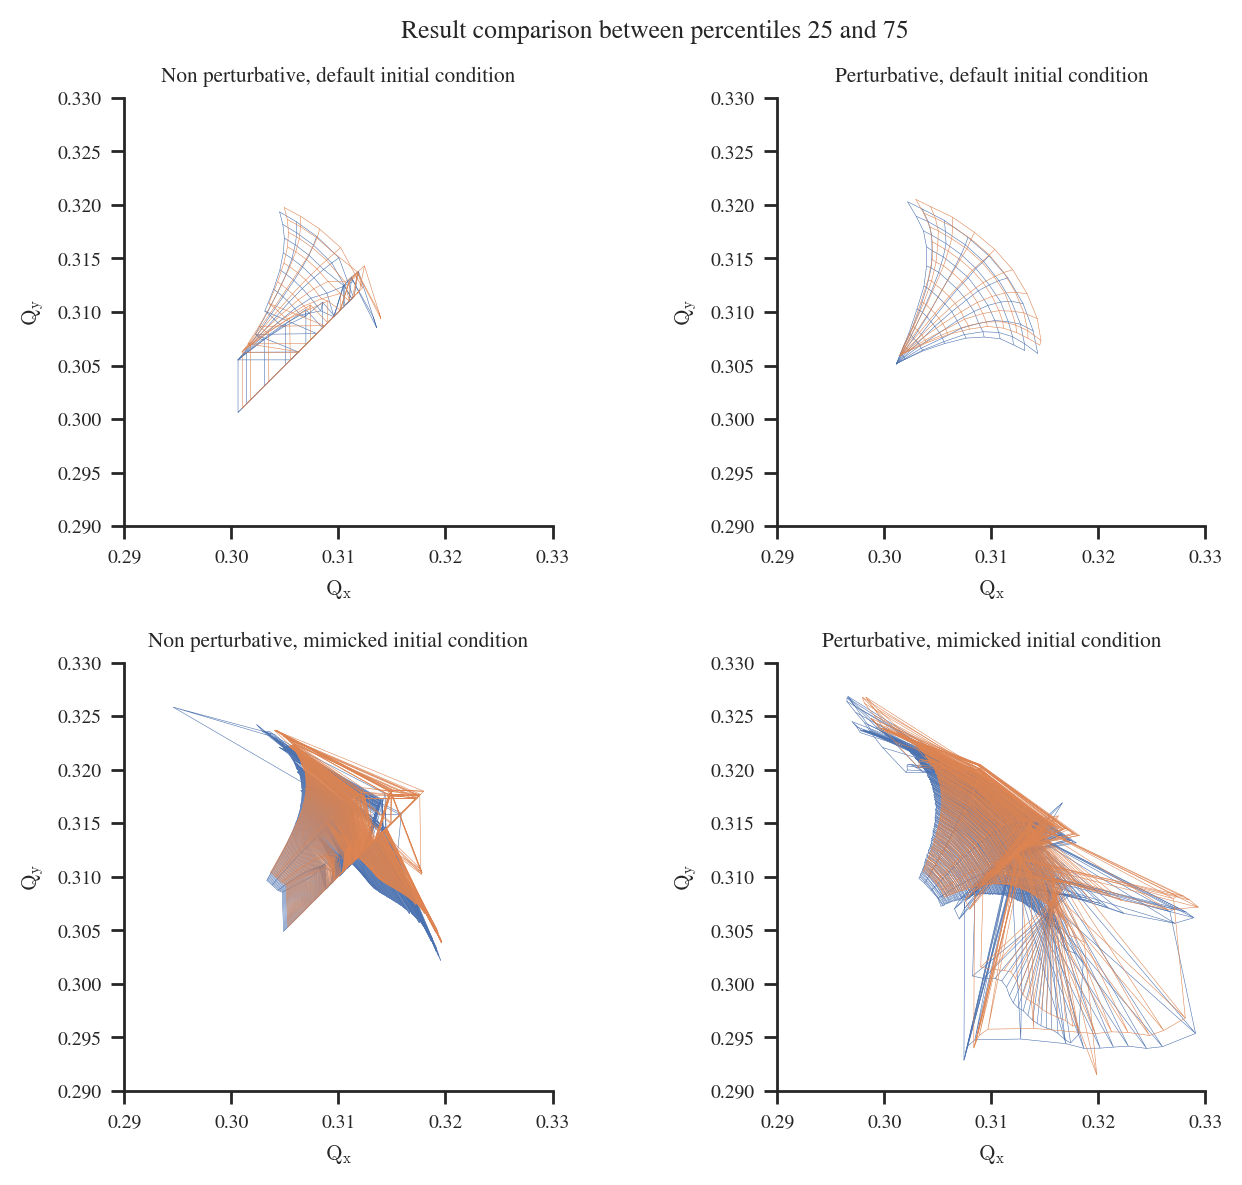

In [81]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('output/compare_footprints.pdf') as export_pdf:
    # Plot initial conditions
    fig, axs = plt.subplots(1, 2, figsize=(2*3.5, 1*3))

    # Plot default initial condition
    ax = axs[0]
    r_range = (0.1, 6)
    theta_range = (0.05, np.pi/2-0.05)
    n_r = 10
    n_theta = 10
    radial_list = np.linspace(r_range[0], r_range[1], n_r, endpoint=True)
    theta_list = np.linspace(theta_range[0], theta_range[1], n_theta, endpoint=True)
    radial_mesh, theta_mesh = np.meshgrid(radial_list, theta_list)
    x_mesh = radial_mesh * np.cos(theta_mesh)
    y_mesh = radial_mesh * np.sin(theta_mesh)
    ax.set_title("Default initial condition")
    ax.set_xlabel(r"$x [\sigma]$")
    ax.set_ylabel(r"$y [\sigma]$")
    ax.plot(x_mesh, y_mesh, color="C0")
    ax.plot(x_mesh.T, y_mesh.T, color="C0")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.grid()
    ax.set_aspect('equal')

    # Plot mimicked initial condition
    ax = axs[1]
    r_max, r_min = 10, 2
    radial_list_to_mimic = np.linspace(r_min, r_max, 2 * 16 * (r_max - r_min), endpoint=False)
    n_angles = 5
    theta_list_to_mimic = np.linspace(0, 90, n_angles + 2)[1:-1]
    radial_list = np.linspace(radial_list_to_mimic[0], radial_list_to_mimic[-1], len(radial_list_to_mimic), endpoint=True)
    theta_list = np.linspace(theta_list_to_mimic[0]/180*np.pi, theta_list_to_mimic[-1]/180*np.pi, len(theta_list_to_mimic), endpoint=True)
    radial_mesh, theta_mesh = np.meshgrid(radial_list, theta_list)
    x_mesh = radial_mesh * np.cos(theta_mesh)
    y_mesh = radial_mesh * np.sin(theta_mesh)
    ax.set_title("Mimicked initial condition")
    ax.set_xlabel(r"$x [\sigma]$")
    ax.set_ylabel(r"$y [\sigma]$")
    ax.plot(x_mesh, y_mesh, color="C1")
    ax.plot(x_mesh.T, y_mesh.T, color="C1")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.grid()
    plt.suptitle("Initial conditions for the footprints")
    #plt.tight_layout()
    plt.show()
    export_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    for bunch_nb, DA, percentile in zip(l_bunch_nb_sampled, l_DA_sampled, [0,25,50,75,100]):
        l_fp = dic_footprints[bunch_nb]

        # Make a grid of 2*2 plots for the footprints
        n_cols = 2
        n_rows = 2
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3),)
        for i, (fp, title) in enumerate(zip(l_fp, ['Non perturbative, default initial condition', 'Perturbative, default initial condition', 'Non perturbative, mimicked initial condition', 'Perturbative, mimicked initial condition'])):
            ax = axs[i//n_cols, i%n_cols]
            ax.plot(fp[0], fp[1], color="C0" if i<2 else "C1")
            ax.plot(fp[0].T, fp[1].T, color="C0" if i<2 else "C1")
            ax.set_xlabel(r"$\mathrm{Q_x}$")
            ax.set_ylabel(r"$\mathrm{Q_y}$")
            ax.set_xlim(0.29, 0.33)
            ax.set_ylim(0.29, 0.33)
            ax.grid()
            #ax.set_aspect("equal")
            ax.set_title(title)
            ax.set_aspect('equal')

        plt.suptitle(f"Footprints for bunch = {int(bunch_nb)} with DA = {DA} (DA percentile {np.round(percentile, 2)})")
        #plt.axis('square')
        plt.tight_layout()
        plt.show()
        export_pdf.savefig(fig, bbox_inches='tight')
        plt.close()
